<a href="https://colab.research.google.com/github/kkrunal77/EVA/blob/master/DN_with_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import skimage
print(np.__version__)
print(skimage.__version__)

import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import gc
print(tf.__version__)

import matplotlib.pyplot as plt
% matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import imgaug.augmenters as iaa

from PIL import Image
import random

1.16.4
0.15.0
1.14.0


In [2]:
!git clone https://github.com/albu/albumentations.git

fatal: destination path 'albumentations' already exists and is not an empty directory.


In [0]:
# from albumentations.augmentations.transforms import RandomFog

In [0]:
from albumentations import (
    Compose, HorizontalFlip, Rotate, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma, JpegCompression,
    ToFloat, ShiftScaleRotate, RGBShift,PadIfNeeded
)
import cv2

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [0]:
# !pip install -U git+https://github.com/albu/albumentations

In [0]:
# from albumentations import (
#     HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
#     Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
#     IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,RandomFog,
#     IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, ChannelDropout, ChannelShuffle,RandomContrast
# )

In [0]:
from albumentations import (HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
                            Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
                            IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
                            IAASharpen, IAAEmboss, Flip, OneOf, Compose, ChannelShuffle,RandomContrast, RandomCrop)

In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 0.125 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}
cutout_proba = 0.2
ssr_proba = 0.15
strong_aug_proba = 0.05

start_reg_ssr = 5
end_reg_ssr = 24
start_reg_cutout = 6 # or 5
end_reg_cutout = 24

start_strong_aug = 3
end_strong_aug = 12

mixed_precision = False
xla_enabled = False

In [8]:
# Half Precision Checks
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True

print("TensorFlow version is", tf.__version__)

try:
    # check and assert TensorFlow >= 1.14
    tf_version_list = tf.__version__.split(".")
    if int(tf_version_list[0]) < 2:
        assert int(tf_version_list[1]) >= 14
except:
    print("TensorFlow 1.14.0 or newer is required.")
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
assert check_tensor_core_gpu_present() == True

TensorFlow version is 1.14.0
Tensor Core GPU Present: True


In [0]:
if xla_enabled:
    config = tf.ConfigProto()
    jit_level = tf.OptimizerOptions.ON_1
    config.graph_options.optimizer_options.global_jit_level = jit_level

    sess = tf.Session(config=config)
    tf.keras.backend.set_session(sess)


In [0]:
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, 
                      v_l=-1,v_h=1,
                      max_erasures_per_image=1, pixel_level=True):
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        shape = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        mx = np.random.randint(1, max_erasures_per_image + 1)
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            if pixel_level:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c
        return input_img

    return eraser

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)


class ConvBN(tf.keras.Model):
    def __init__(self, c_out):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))
    
    
class SepConvBN(tf.keras.Model):
    def __init__(self,c):
        super().__init__()
        self.conv = tf.keras.layers.SeparableConv2D(filters=c, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))
    
    
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super().__init__()
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h
    
    
class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.drop1 = tf.keras.layers.Dropout(0.25)
        self.blk2 = ResBlk(c*4, pool)
        self.drop2 = tf.keras.layers.Dropout(0.2)
        self.blk3 = ResBlk(c*4, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight

    def call(self, x, y):
        h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [0]:
# Cifar10 Augmentation Policy


In [0]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random


class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.

        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.

        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.8, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.

        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0)),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1]))),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            # "rotate": lambda img, magnitude: img.rotate(magnitude * random.choice([-1, 1])),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        # self.name = "{}_{:.2f}_and_{}_{:.2f}".format(
        #     operation1, ranges[operation1][magnitude_idx1],
        #     operation2, ranges[operation2][magnitude_idx2])
        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

In [14]:
print(gc.collect())

model = DavidNet(weight=0.125)
batches_per_epoch = len_train//BATCH_SIZE + 1

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]

# lr_schedule = lambda t: np.interp([t], [0.0001, (EPOCHS+1)//5, EPOCHS-3, EPOCHS-2,EPOCHS-1, EPOCHS], [0, LEARNING_RATE, 0.09,0.06,0.03,0.001])[0]
# lr_schedule = lambda t: np.interp([t], [0.0001, (EPOCHS+1)//5, EPOCHS-3, EPOCHS-2,EPOCHS-1, EPOCHS], [0, 0.4, 0.08,0.07,0.03,0.001])[0]


# lr_schedule = lambda t: np.interp([t], [0, 2, (EPOCHS+1)//5, EPOCHS-3, EPOCHS], [0.0001,0.3, LEARNING_RATE,0.1, 0.01])[0]

# lr_schedule = lambda t: np.interp([t], 
#                                   [0, 2, 5,12, 15, EPOCHS-2, EPOCHS], 
#                                   [0.0001,0.3, LEARNING_RATE,0.001,0.005,0.01, 0.001])[0]

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS-1, EPOCHS], [0, LEARNING_RATE,0.025, 0.01])[0]

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS-1,EPOCHS], [0, LEARNING_RATE,0.05, 0.01])[0]

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS-1,EPOCHS], [0, LEARNING_RATE, 0.01,0.01])[0]

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS-1,EPOCHS], [0, LEARNING_RATE, 0.02,0.01])[0]



global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

if mixed_precision:
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)

# data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
# data_aug2 = lambda x,y: (tf.image.random_hue(tf.image.random_brightness(x,max_delta=0.1),max_delta=0.1),y)


# data_aug1 = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
# data_aug2 = lambda x,y: (tf.image.random_hue(tf.image.random_brightness(x,max_delta=0.1),max_delta=0.1),y)
# data_aug3 = lambda x, y: (tf.image.random_contrast(tf.image.random_saturation(x, 0.7, 1.3),0.7, 1.3), y)

def multipe_aug(x, y):
    x = tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3]))
    x = tf.image.random_hue(tf.image.random_brightness(x,max_delta=0.1),max_delta=0.1)
    x = tf.image.random_contrast(tf.image.random_saturation(x, 0.7, 1.3),0.7, 1.3)
    return x, y

data_aug = lambda x, y: multipe_aug(x, y)
# tf.image.random_contrast(image,lower,upper)


# 
cutout_fn = get_cutout_eraser(p=1.0, pixel_level=True)

def batch_cut(imgs, epoch):
    if epoch>=end_reg_cutout or epoch<=start_reg_cutout:
        return imgs
    for i,im in enumerate(imgs):
        p_1 = np.random.rand()
        if p_1 > cutout_proba:
            continue
        else:
            imgs[i] = cutout_fn(im)
    return imgs

# rotate_one = lambda x : tf.keras.preprocessing.image.random_rotation(x, rg=45, row_axis=0,col_axis=1,channel_axis=2)
ssr = ShiftScaleRotate(p=ssr_proba)
rotate_one = lambda x: ssr(image=x)['image']
def rotate(imgs,epoch):
    if epoch>=end_reg_ssr or epoch<=start_reg_ssr: # 15=93.4 # 10 =93.1 # 20=93.4
        return imgs
    for i,im in enumerate(imgs):
        imgs[i] = rotate_one(im)
    return imgs


# AUGMENTATIONS_TRAIN = Compose([
#     HorizontalFlip(p=0.5),#
#     RandomContrast(limit=0.2, p=0.5),#
#     RandomGamma(gamma_limit=(80, 120), p=0.5),#
#     RandomBrightness(limit=0.2, p=0.5),#
#     HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
#                        val_shift_limit=10, p=.9),
#     CLAHE(p=1.0, clip_limit=2.0),
#     ShiftScaleRotate(
#         shift_limit=0.0625, scale_limit=0.1, 
#         rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
#     # Rotate(limit=15, border_mode=cv2.BORDER_REFLECT_101),
#     # JpegCompression(quality_lower=50, quality_upper=100, p=0.5),
#     ToFloat(max_value=255)
# ])


# AUGMENTATIONS_TEST = Compose([
#     CLAHE(p=1.0, clip_limit=2.0),
#     ToFloat(max_value=255)
# ])


AUGMENTATIONS_TRAIN = Compose([GaussNoise(p=0.25),
                      RandomContrast(limit=0.2, p=0.5),
                      HorizontalFlip(p=0.5),
                      GridDistortion(num_steps=8, distort_limit=0.3,p=1.0),
                      RandomCrop(40,40,p=1.0),
                      PadIfNeeded(40,40),
#                       RandomBrightness(limit=0.2, p=0.5),
#                       RandomGamma(gamma_limit=(80, 120), p=0.5),
#                       RandomContrast(p=0.25),
#                       RGBShift(),
#                       HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20, 
#                                          val_shift_limit=10, p=.9),
                      
                      ShiftScaleRotate(shift_limit=0.052, scale_limit=0.1, 
                                       rotate_limit=0, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
                      
                      ChannelShuffle(p=0.25),
                      OneOf([MedianBlur(blur_limit=3, p=0.25),
                             Blur(blur_limit=3, p=0.25),], 
                            p=0.5)],
                     p=strong_aug_proba)


mix_aug = lambda x: AUGMENTATIONS_TRAIN(image=x)['image']
def strong_augs(imgs,epoch):
    if epoch>=end_strong_aug or epoch<=start_strong_aug: # 15=93.4 # 10 =93.1 # 20=93.4
        return imgs
    for i,im in enumerate(imgs):
        imgs[i] = mix_aug(im)
    return imgs


rendom_aug = lambda x: CIFAR10Policy()(Image.fromarray(x, 'RGB'))
def cifar10policy(imgs,epoch):
    if epoch>=12 or epoch<=0: # 15=93.4 # 10 =93.1 # 20=93.4
        return imgs
    for i,im in enumerate(imgs):
        imgs[i] = rendom_aug(im)
    return imgs


def combined_aug(imgs,epoch):
    imgs = np.copy(imgs)
    imgs = rotate(imgs,epoch)
    imgs = batch_cut(imgs,epoch)
    imgs = strong_augs(imgs,epoch)
#     imgs = cifar10policy(imgs,epoch) #working But Taking more time 
    return imgs

# 19 - 93.6
# 20 - 93.9


0


In [0]:
# albumentations.augmentations.transforms.RandomFog
# from albumentations.augmentations.transforms.albumentations.RGBShift()

In [0]:
# lr_schedule = lambda t: np.interp([t], [0.0001, (EPOCHS+1)//5, EPOCHS-3, EPOCHS-2,EPOCHS-1, EPOCHS-0.1], [0, 0.4, 0.08,0.05,0.01,0.001])[0]
# lr_schedule = lambda t: np.interp([t], [0,     3,    5,    10,    16,    19,   22,   23  ,24], 
#                                        [0.04,  0.3, 0.43,  0.16, 0.06, 0.04, 0.01, 0.001, 0.0001])[0]

lr=[]
ep=[]
for i in range(25):
    lr.append(lr_schedule(i))
    ep.append(i)

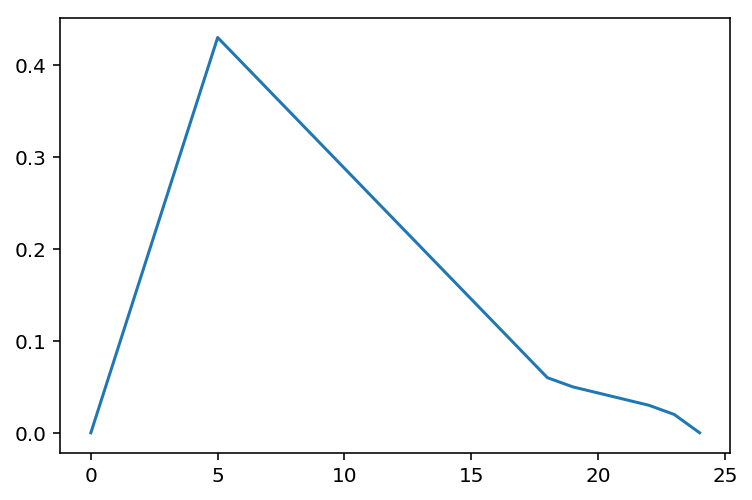

In [26]:
# This LR best 20 epoch
lr_schedule = lambda t: np.interp([t], [0.001, 5, 18, 19, 22, 23, 24], [0, 0.43, 0.06, 0.05, 0.03,0.02,0.0001])[0]
import matplotlib.pyplot as plt 
plt.plot(ep, lr)

In [0]:

# t1 = time.time()
# train_data = {}
# for epoch in range(EPOCHS):
#     xt = combined_aug(x_train, epoch)
#     train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(data_aug2, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
# #     train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(BATCH_SIZE).prefetch(len_train)
#     i = 0
#     for x,y in train_set:
#         assert x.numpy().shape[0]==len_train
#         train_set = (x.numpy(),y.numpy())
#         i = i+1
#     assert i==1
#     train_data[epoch] = train_set
#     print(i)
# t2 = time.time()
# "%.1f" %(t2-t1)

In [0]:
print(gc.collect())
t1 = time.time()
train_data = {}
print("Store data rpoch wise ")
for epoch in range(EPOCHS):
    
    if epoch%2!=0:
        print("Epoch = ",epoch," Time = ",(time.time()-t1))
        
    xt = combined_aug(x_train, epoch)
    train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
    i = 0
    for x,y in train_set:
        assert x.numpy().shape[0]==len_train
        train_set = (x.numpy(),y.numpy())
        i = i+1
    assert i==1
    train_data[epoch] = train_set
t2 = time.time()
"%.1f" %(t2-t1)

In [0]:
# print(train_data)

In [0]:
print(gc.collect())
t = time.time()
t_last = time.time()
train_accs = []
test_accs = []

test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(1)

for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    
    train_set = train_data[epoch]
    train_set = tf.data.Dataset.from_tensor_slices(train_set).batch(BATCH_SIZE).prefetch(1)
    tf.keras.backend.set_learning_phase(1)
#     xt = combined_aug(x_train, epoch)
#     train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(data_aug2, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(BATCH_SIZE).prefetch(len_train)
#     train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(BATCH_SIZE).prefetch(len_train)

    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * (WEIGHT_DECAY/(epoch+1)) * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

    tf.keras.backend.set_learning_phase(0)
    for (x, y) in test_set:
        loss, correct = model(x, y)
        test_loss += loss.numpy()
        test_acc += correct.numpy()

    t2 = time.time()
    epoch_time = t2 - t_last
    t_last = t2
    train_accs.append(train_acc / len_train)
    test_accs.append(test_acc / len_test)
    print("epoch: %s"%(epoch+1),'lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.4f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), 'val acc: %.4f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))
    
    
plt.figure()
plt.plot(train_accs[3:])
plt.plot(test_accs[3:])
plt.show()

0
epoch: 1 lr: 0.0859 | train loss: 0.1345 train acc: 0.9566 val loss: 0.2680 val acc: 0.9107 epoch time: 28.32 time: 28.32
epoch: 2 lr: 0.1719 | train loss: 0.1336 train acc: 0.9568 val loss: 0.2679 val acc: 0.9109 epoch time: 28.55 time: 56.88
epoch: 3 lr: 0.2580 | train loss: 0.1280 train acc: 0.9601 val loss: 0.2678 val acc: 0.9115 epoch time: 28.76 time: 85.63
epoch: 4 lr: 0.3440 | train loss: 0.1233 train acc: 0.9619 val loss: 0.2683 val acc: 0.9109 epoch time: 28.32 time: 113.96
epoch: 5 lr: 0.4300 | train loss: 0.1830 train acc: 0.9403 val loss: 0.2694 val acc: 0.9098 epoch time: 28.39 time: 142.35
epoch: 6 lr: 0.4015 | train loss: 0.1756 train acc: 0.9423 val loss: 0.2691 val acc: 0.9105 epoch time: 28.37 time: 170.71


In [0]:
# lr_schedule = lambda t: np.interp([t], [0.001, 5, 18, 19, 22, 23, 24], [0, 0.43, 0.06, 0.05, 0.03,0.02,0.0001])[0]

In [0]:
lr_schedule = lambda t: np.interp([t], [0.0001, (EPOCHS+1)//5, EPOCHS-3, EPOCHS-2,EPOCHS-1, EPOCHS], [0, LEARNING_RATE, 0.09,0.06,0.03,0.001])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE